## Labels suggestions for Incidents

While creating incidents (Bugs/Epics). It is recommended and is considered a good practice to attach labels to the incidents as fetching them later becomes easy. Through this model the incident creator will be given suggestions about the label which can be attached.
  
Approach which I use is:
1. TFIDF with logistic regression and binary relevance
2. BERT for finding semantic embeddings


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import pickle
import warnings; warnings.simplefilter('ignore')
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
import gensim
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from wordcloud import WordCloud
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util
from sentence_transformers import models, losses
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity


Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (2.0.0)


In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading StackOverflow Question Data and Jira Data

In [113]:
# Reading Stackoverflow dataset and Jira dataset
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/questions.csv', usecols=['questions', 'tags'])
jira_data=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/jira_data/jira_dataset_prediction.csv')
df.head(10)

,questions,tags
0,How to display jalali date in to view in Codei...,"php,codeigniter,date,gregorian-calendar"
1,Automate creating of sales order in Zoho Books,"python-3.x,zohobooks"
2,java jar error for spring boot applicaton,"java,spring,spring-boot"
3,Not able to run UnfoldingMap library,"java,eclipse,dictionary,core,unfoldingmap"
4,Serverless Graphql Lambda hard to understand t...,"typescript,webpack,error-handling,graphql,serv..."
5,Dictionary data structure in React JS,reactjs
6,applying CSS for particular td tag in a column,"html,css"
7,Can anybody tell me the regex that matches twe...,"python-3.x,regex,nlp"
8,How to check whether an image is labelled or not?,labeling
9,kubernates networking python server in tomcat ...,"python,docker,kubernetes,port,netstat"


Amount of data (Dataframe Size)

In [115]:
print(df.shape)
jira_df = jira_data.filter(['Summary','Description','Assignee','Tags'])
jira_df["Description"].fillna(jira_df['Summary'], inplace = True)

(529804, 2)


### Data cleaning

In [90]:
df = df.dropna()
df.rename(columns = {'questions':'title'}, inplace = True)

### Clean title

For Text Classification, the Title is cleaned by only allowing keeping of Alphabets, Numbers and few other relevant symbols in the quesiton title. In the next step, Tokenization will only keep up words based on spaces. 

In [91]:
def clean_text(text):
    text = str(text)
    text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
    return text

df['title'] = df['title'].apply(clean_text)
df.head(10)

,title,tags
0,how to display jalali date in to view in codei...,"php,codeigniter,date,gregorian-calendar"
1,automate creating of sales order in zoho books,"python-3.x,zohobooks"
2,java jar error for spring boot applicaton,"java,spring,spring-boot"
3,not able to run unfoldingmap library,"java,eclipse,dictionary,core,unfoldingmap"
4,serverless graphql lambda hard to understand t...,"typescript,webpack,error-handling,graphql,serv..."
5,dictionary data structure in react js,reactjs
6,applying css for particular td tag in a column,"html,css"
7,can anybody tell me the regex that matches twe...,"python-3.x,regex,nlp"
8,how to check whether an image is labelled or not,labeling
9,kubernates networking python server in tomcat ...,"python,docker,kubernetes,port,netstat"


## Exploration 

Basic exploration over here. Trying to look at things like the number of words in vocabulary, number of tags, and variation of number of tags in questions. 

In [92]:
#Convert dataset to list
questions = df['title'].tolist()
tags = df['tags'].tolist()

### Number of words in the vocabulary

In [93]:
print('The total number of words in the data is: ', sum([len(text.split()) for text in questions]))

def tokenize_question(text):
    return text.split()

question_vect = CountVectorizer(tokenizer=tokenize_question)
question_vect.fit(questions)

print('The number of words in the vocabulary is: ', len(question_vect.vocabulary_))

The total number of words in the data is:  5405579
The number of words in the vocabulary is:  111750


### Total Category of Tags

In [94]:
def tokenize_tags(text):
    return text.split(',')

tags_vect = CountVectorizer(tokenizer=tokenize_tags)
tags_vect.fit(tags)

print('The total number of tags is: ', len(tags_vect.vocabulary_))

The total number of tags is:  33332


### Converting Tag Labels to vectorized tokens.

There are too many tags to predict. In our model we will only look at the top 100 tags and save the result

In [95]:
max_tags = 100

def tokenize_tags(text):
    return text.split(',')

tags_vect = CountVectorizer(tokenizer=tokenize_tags, max_features=max_tags)
tags = tags_vect.fit_transform(tags)
tags = tags.toarray()
print('Number of tags: ', len(tags_vect.vocabulary_))

tags_token = tags_vect.get_feature_names()
tag_frequency = tags.sum(axis=0)
print('The list of tags with frequency is: ')
print(dict(zip(tags_token, tag_frequency)))

Number of tags:  100
The list of tags with frequency is: 
{'.net': 3777, '.net-core': 2131, 'ajax': 2412, 'algorithm': 2144, 'amazon-web-services': 6529, 'android': 20113, 'android-studio': 3205, 'angular': 10146, 'apache-spark': 2669, 'api': 4273, 'arrays': 9132, 'asp.net': 2686, 'asp.net-core': 3787, 'azure': 4487, 'bash': 2774, 'c': 7983, 'c#': 21718, 'c++': 14385, 'css': 15275, 'csv': 2169, 'dart': 5270, 'database': 3705, 'dataframe': 7009, 'dictionary': 2321, 'discord': 2171, 'discord.py': 1952, 'django': 9860, 'docker': 5983, 'excel': 6675, 'express': 3732, 'firebase': 5930, 'flask': 2501, 'flutter': 11605, 'for-loop': 2148, 'function': 3036, 'ggplot2': 1943, 'git': 3308, 'github': 1936, 'go': 2089, 'google-apps-script': 2146, 'google-cloud-firestore': 2568, 'google-cloud-platform': 2104, 'google-sheets': 2562, 'html': 22563, 'image': 1985, 'ios': 7924, 'java': 30188, 'javascript': 58702, 'jquery': 7920, 'json': 7690, 'keras': 2469, 'kotlin': 4837, 'kubernetes': 2956, 'laravel': 

### Data Analysis

In [96]:
tag_count = [[x[0],x[1]] for x in zip(tags_token, tag_frequency)]
tag_count = sorted(tag_count, key = lambda x: x[1], reverse=True)
count_df = pd.DataFrame(data = tag_count)
count_df.rename(columns = {0:'Tags',1:'Frequency'}, inplace = True)
print(count_df.head(10))

         Tags  Frequency
0      python      81665
1  javascript      58702
2        java      30188
3     reactjs      25686
4        html      22563
5          c#      21718
6     android      20113
7         php      17988
8     node.js      17350
9  python-3.x      15755


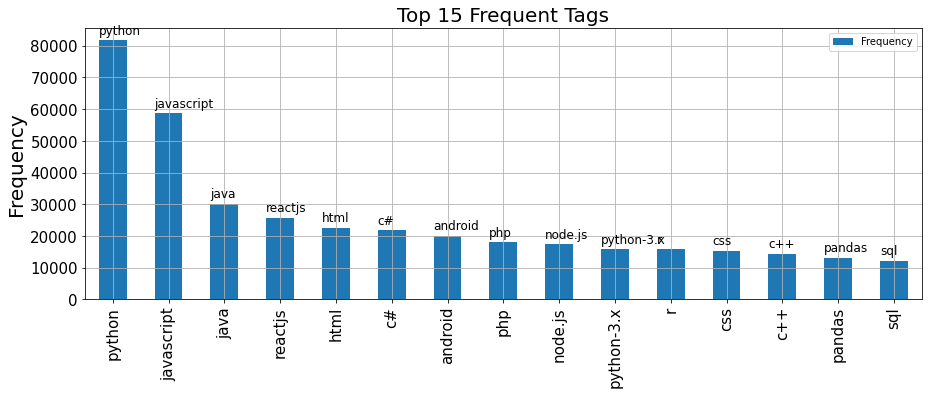

In [ ]:
# Top 15 Frequent Tags with their frequency
axes = count_df.head(15).plot(x = 'Tags', y = 'Frequency', kind = 'bar', figsize = (15, 5), fontsize = 15, grid = True)
plt.xlabel("")
plt.ylabel("Frequency", fontsize = 20)
plt.title("Top 15 Frequent Tags", fontsize = 20)
cnt = 0
for i in axes.patches:
    axes.text(i.get_x(), i.get_height()+2000, count_df.head(15)['Tags'][cnt], fontsize=12, color='black')
    cnt +=1

### Number of Tags per Question Histogram

Text(0, 0.5, 'Number of title')

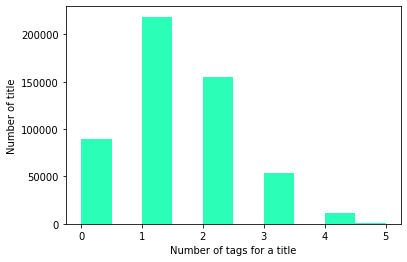

In [ ]:
import seaborn as sns
plt.hist(tags.sum(axis=1),color=sns.xkcd_rgb['greenish cyan'])
plt.xlabel('Number of tags for a title')
plt.ylabel('Number of title')

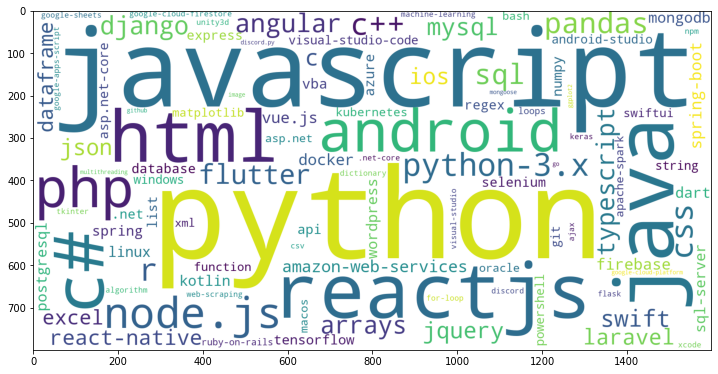

In [ ]:
# Word Web for the Tags Frequency
tup = dict(tag_count)
wordcloud = WordCloud( background_color='white',width=1600,height=800,).generate_from_frequencies(tup)
fig = plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.show()

## Split data into train, validation and test set

Splitting data into 80, 20, 20

In [97]:
X_train, X_test, y_train, y_test = train_test_split(questions, tags, 
                                                    test_size=0.2, 
                                                    random_state=random_state)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5, 
                                                    random_state=random_state)

## Evaluation metrics
 

In [98]:
def eval_metrics(y_test, y_predicted, print_metrics=True):
    
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    if print_metrics:
        print("f1: %.3f - precision: %.3f - recall: %.3f - accuracy: %.3f" % (
            f1, precision, recall, accuracy))
    return f1, precision, recall, accuracy

# TFIDF on Bag of Words with SGD and logistic regression

### TFIDF on bag of words embedding

The Questions are first coverted into into Bag of Words embedding. The idea here is that we want to find the association with the kind of words which appear for a particular tag. 

On top of the bag of words embedding, we apply TF-IDF score (Term Frequency, Inverse Document Frequency). TF-IDF weighs the words to reduce effect of common words appearing too frequently which act as noise.

In [99]:
def tokenize_question(text):
    return text.split()

tfidf_vect = TfidfVectorizer(tokenizer=tokenize_question,
                               stop_words='english',
                               min_df=4,
                               max_df=0.5)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
print('The number of words in the vocabulary is: ', len(tfidf_vect.vocabulary_))

The number of words in the vocabulary is:  21511


SGD Model 

In [ ]:
# Importing SGD classifier
from sklearn import linear_model
sgd = linear_model.SGDClassifier()
clf = OneVsRestClassifier(sgd)
clf.fit(X_train_tfidf, y_train)


Training the SGD Model

In [ ]:
print('Train score')
y_train_clf_predict = clf.predict(X_train_tfidf)
eval_metrics(y_train, y_train_clf_predict)

Train score
f1: 0.451 - precision: 0.753 - recall: 0.340 - accuracy: 0.339


(0.45060756826886644,
 0.7534052177132462,
 0.3395613021463247,
 0.33869616815660514)

Testing SGD Model

In [ ]:
print('Test score')
y_test_clf_predict = clf.predict(X_test_tfidf)
eval_metrics(y_test, y_test_clf_predict)

Test score
f1: 0.449 - precision: 0.748 - recall: 0.339 - accuracy: 0.337


(0.44863544961656016,
 0.7481925132565803,
 0.338714689074722,
 0.33685660897302805)

# Classification Model

Recommending Tags to an incident is a multi-label classification problem. So we are using one vs rest classifier on top of logistic regression. 

In [ ]:
#Estimated time to run ~15min
%%time
tfidf_log_clf = OneVsRestClassifier(LogisticRegression())

tfidf_log_clf.fit(X_train_tfidf, y_train)



CPU times: user 10min 47s, sys: 11min 40s, total: 22min 28s
Wall time: 11min 26s


### Train evaluation metrics

In [ ]:
print('Train score')
y_train_tfidf_predict = tfidf_log_clf.predict(X_train_tfidf)
eval_metrics(y_train, y_train_tfidf_predict)

Train score
f1: 0.549 - precision: 0.789 - recall: 0.434 - accuracy: 0.382


(0.549114600396543, 0.789068706573853, 0.43358218257403996, 0.3820589227614942)

### Results

Performance on the Test data

In [ ]:
print('Test score')
y_test_tfidf_predict = tfidf_log_clf.predict(X_test_tfidf)
eval_metrics(y_test, y_test_tfidf_predict)

Test score
f1: 0.528 - precision: 0.761 - recall: 0.416 - accuracy: 0.364


(0.5278847230539101,
 0.7612356429645453,
 0.41577390200078357,
 0.3639417904531813)

In [ ]:
#Prediction on Stack overflow data
n_examples = 20
thres = 0.2

print('Test score')
y_test_tfidf_predict = model.predict(X_test_tfidf)
eval_metrics(y_test, y_test_tfidf_predict)

preds = y_test_tfidf_predict[:n_examples,:]>thres

print('Title: ', X_test[20])
print('Tags: ', [tags_token[20] for i in np.where(preds[i,:] == 1)[0].tolist()])

Test score
f1: 0.528 - precision: 0.760 - recall: 0.416 - accuracy: 0.341
Question:  svg images are not inserted in pdf while generating a pdf from html using itex7 html2pdf plugin
Tags:  ['dart']


Saving Model as pickle file

In [ ]:
# save tfidf model --This is done so that we don't need to train the model again--
with open('tfidf_log_clf','wb') as f:
  pickle.dump(tfidf_log_clf,f) 

In [116]:
# Jira dataset analysis
jira_data.head(2)

,Summary,Tags,Issue key,Issue id,Parent id,Issue Type,Status,Project key,Project name,Project type,Project lead,Project description,Project url,Priority,Resolution,Assignee,Reporter,Creator,Created,Updated,Last Viewed,Resolved,Due Date,Votes,Labels,Description,Environment,Watchers,Watchers.1,Log Work,Log Work.1,Original Estimate,Remaining Estimate,Time Spent,Work Ratio,Σ Original Estimate,Σ Remaining Estimate,Σ Time Spent,Security Level,Inward issue link (Cloners),Inward issue link (Cloners).1,Outward issue link (Cloners),Inward issue link (Relates),Inward issue link (Relates).1,Inward issue link (Relates).2,Outward issue link (Relates),Outward issue link (Relates).1,Outward issue link (Relates).2,Outward issue link (Relates).3,Custom field (Epic Color),Custom field (Epic Link),Custom field (Epic Name),Custom field (Epic Status),Custom field (Rank),Sprint,Sprint.1,Custom field (Story Points),Comment,Comment.1
0,Help other team with classification model,"classification, machine learning, development,...",PITL1-141,11693,NaN,Task,Done,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,Done,zhiyiniu,nikanmog,nikanmog,6/26/2021 14:42,6/28/2021 18:10,6/28/2021 23:42,6/28/2021 18:10,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i004by:,Sprint 3 - Week 2,NaN,NaN,NaN,NaN
1,Create json for chord graph,"json, web app, front end",PITL1-140,11692,NaN,Task,Open,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,NaN,ga65hif,nikanmog,nikanmog,6/26/2021 14:41,6/26/2021 14:41,6/28/2021 23:44,NaN,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i004bx:,Sprint 3 - Week 2,NaN,NaN,NaN,NaN


In [127]:
#Load model tfidf
model_path = open('/content/drive/MyDrive/Colab_Notebooks/tfidf_log_clf', 'rb')     
model = pickle.load(model_path)

jira_desc_df = jira_df.filter(['Description'])
jira_description = jira_desc_df['Description'].tolist()
jiradf = tfidf_vect.transform(jira_description)
jira_prediction = model.predict(jiradf)

jira_desc_df.head(4)

,Description
0,Help other team with classification model
1,Create json for chord graph
2,Getting analysis result in json
3,Finding a proper graph to display output


In [137]:
# Printing predicted result
no_examples = 3
thres = 0.25

preds = jira_prediction[:no_examples,:]>thres

print('Summary: ', jira_description[2])
print('Tags: ', [tags_token[i] for i in np.where(preds[2,:] == 1)[0].tolist()])

Summary:  Getting analysis result in json 
Tags:  ['json']


In [143]:
# Adding the predited result to a list
total_incidents = len(jira_description)
thres = 0.25

preds = jira_prediction[:total_incidents,:]>thres
predicted_result_list=[]
for i in range(total_incidents):
    predicted_result_list.append([tags_token[i] for i in np.where(preds[i,:] == 1)[0].tolist()])

### Importance words

Lets inspect at some of the important words that the classifer considered in making the recommendation. 

The most common words are actually the tags in the problem. This makes sense because most of the tag will be as a word in the title. 

In [118]:
importances = importances = model.estimators_[0].coef_[0]
for i in range(1,len(model.estimators_)):
    importances += model.estimators_[i].coef_[0]

importances = importances/sum(importances)
    
feature_imps = {'importances':importances, 'feature':tfidf_vect.get_feature_names()}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps[['feature', 'importances', 'cum_imp']].head(5)

,feature,importances,cum_imp
0,python,1.000000,0.044677
1,react,0.946121,0.086947
2,flutter,0.890488,0.126732
3,r,0.869649,0.165585
4,django,0.860471,0.204029


In [119]:
# Using a Description as a sample query i.e assigned incident
query = jira_df['Description'][23]
documents=[]
for i in range(0,len(jira_df['Description'])):
  documents.append(jira_df['Description'][i])
print(query)

# Using a Summary as a sample query i.e assigned incident
summary_query = jira_df['Summary'][23]
summarys=[]
for i in range(0,len(jira_df['Summary'])):
  summarys.append(jira_df['Summary'][i])

Implement spider web visual in web app


# BERT Model Selection and Initialization

In [17]:
# Loading BERT Model
model = SentenceTransformer('stsb-roberta-base-v2')

In [18]:
#Converting the incidents description text to contextual embeddings
query_embedding = model.encode(query, batch_size = 1, show_progress_bar = True)
#text_embeddings = model.encode(df['Description'], batch_size = len(documents), show_progress_bar = True)
text_embeddings = model.encode(documents, batch_size = len(documents), show_progress_bar = True)

In [19]:
#Converting the incidents summary text to contextual embeddings
summary_query_embedding = model.encode(summary_query, batch_size = 1, show_progress_bar = True)
#text_embeddings = model.encode(df['Summary'], batch_size = len(documents), show_progress_bar = True)
summary_text_embeddings = model.encode(summarys, batch_size = len(documents), show_progress_bar = True)

# Computing Similarity of Incidents and Tags Prediction

In [142]:
# Compute similarity scores of the incidents with respect to description 
cos_scores = util.pytorch_cos_sim(query_embedding, text_embeddings)[0]
# Top_k results to return
top_k=2

# Compute similarity scores of the incidents with respect to summary 
cos_scores_summary = util.pytorch_cos_sim(summary_query_embedding, summary_text_embeddings)[0]

#Merge both the description scores and summary scores
total_scores=(0.65)*cos_scores+(0.35)*cos_scores_summary

# Sort the results in decreasing order and get the first top_k result
top_results = np.argpartition(-total_scores, range(top_k))[1:top_k+1]
print("Sentence:", query, "\n")
tag_set=set()
tags_set.update(predicted_result_list[23])
for idx in top_results[1:top_k+1]:
    tag_set.update(set(str(jira_df['Tags'][int(idx)]).split(',')))
print(tag_set)

Sentence: Implement spider web visual in web app 

{'json'}


In [144]:
#Predicting aggregated response for all Jira incidents

aggregate_result=[]
for i in range(len(documents)):
  desc_cos_scores = util.pytorch_cos_sim(text_embeddings[i], text_embeddings)[0]
  # Compute similarity scores of the incidents with respect to summary 
  cos_scores_summary = util.pytorch_cos_sim(summary_text_embeddings[i], summary_text_embeddings)[0]

  #Merge both the description scores and summary scores
  cos_scores=(0.65)*desc_cos_scores+(0.35)*cos_scores_summary
  top_k=2

  top_results = np.argpartition(-cos_scores, range(top_k))[1:top_k+1]
  tags_result=[]
  tags_set=set()
  # Merging results of the tfidf-logistic regression model
  tags_set.update(predicted_result_list[i])
  for idx in top_results[0:top_k]:
      tags_set.update(set(str(jira_df['Tags'][int(idx)]).split(',')))
  tags_result.append({
      "assignee":str(jira_df['Assignee'][int(i)]),
      "summary":str(jira_df['Summary'][int(i)]),
      "tags":str(tags_set)
  })
  aggregate_result.append(tags_result)

In [68]:
print(aggregate_result)

[[{'assignee': 'zhiyiniu', 'summary': 'Help other team with classification model', 'tags': "{' development', 'json', ' machine learning', ' python', 'classification'}"}], [{'assignee': 'ga65hif', 'summary': 'Create json for chord graph', 'tags': "{'json', ' development', ' machine learning', 'R', ' python', 'classification'}"}], [{'assignee': 'zhiyiniu', 'summary': 'Getting analysis result in json ', 'tags': "{'json', ' machine learning', 'R', 'classification', '  web app', ' visualization', ' development', ' python', ' front end'}"}], [{'assignee': 'zhiyiniu', 'summary': 'Finding a proper graph to display output', 'tags': "{' front end', 'json', '  web app'}"}], [{'assignee': 'zhiyiniu', 'summary': 'Counting lines of code changes per person', 'tags': "{' python', ' development', 'json', 'machine learning'}"}], [{'assignee': 'zhiyiniu', 'summary': 'Analysing sentiment score of commit messages', 'tags': "{'python', 'json', 'development'}"}], [{'assignee': 'zhiyiniu', 'summary': 'Classif

In [145]:
# Exporting result as JSON
import json
response=json.dumps(aggregate_result)
with open("response.json", "w") as outfile:
    outfile.write(response)